In [1]:
import cuentitas
from cuentitas import a0VV, a1VVF1, a1VVF2
import auxiliaresGNSS as au

from numpy import pi, sqrt, sin, cos, exp, log10, array, real, conj
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import interpolate
import seaborn as sns
import pandas as pd
import glob
import theano.tensor as TT
import time

import pymc3 as pm
import random 
sns.set()

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import theano.tensor as T

In [3]:
# s0 = patron(epsilon1,epsilon2,de,ssup,sinf,altura)
def patron(ep,s,ZA):


    landa = 0.19
    k0 = 2*np.pi/landa
    phi = 0
    ph = phi
    th = thi

    # sigmaFran(1, ep, 0.1, 0.001, 0.01, s, l, incAng[j], landa[k])
    # s0 = au.generadorS0_Fran(ep1,ep2,d,s1,s2,ZA)
    s0 = au.generadorS0(thi,1,ep,0.1,0.01,s,ZA)

    nn = len(thi)
    
    a = TT.zeros(nn)

    for i in range(nn):
        a = TT.set_subtensor(a[i], s0[i])
        
    return a

In [4]:
def patron_ruidoso(ep,s,ZA):

    landa = 0.19
    k0 = 2*np.pi/landa
    phi = 0
    ph = phi
    th = thi

    # sigmaFran(1, ep, 0.1, 0.001, 0.01, s, l, incAng[j], landa[k])
    # s0 = au.generadorS0_Fran(ep1,ep2,d,s1,s2,ZA)
    s0 = au.generadorS0ruido(thi,1,ep,0.1,0.01,s,ZA,noise)

    nn = len(thi)
    
    a = TT.zeros(nn)

    for i in range(nn):
        a = TT.set_subtensor(a[i], s0[i])
        
    return a

In [83]:
# def modelo(medidos,errores,samples,thi): 
def modelo(medidos,errores,samples): 

    RANDOM_SEED = 58
    ranges = {}
    # ranges['ep1'] = 4, 40
    # ranges['ep2'] = 4, 40
    # ranges['d'] = 0.03, 0.15
    # ranges['s1'] = 0.005, 0.02
    # ranges['s2'] = 0.005, 0.02
    # ranges['Za'] = 3, 3.5

    ranges['ep'] = 4, 40
    ranges['s'] = 0.001, 0.02
    ranges['Za'] = 2.9, 3.1

    with pm.Model() as model:
        ep = pm.Uniform('ep', ranges['ep'][0], ranges['ep'][1])
        s = pm.Uniform('s', ranges['s'][0], ranges['s'][1])
        Za = pm.Uniform('Za', ranges['Za'][0], ranges['Za'][1])

    def f(ep = ep,
          s = s,
          Za = Za):
        # return patron(ep1,ep2,d,s1,s2,Za)
        return patron(ep,s,Za)
    
    with model:
        function_pm = pm.Deterministic('s0f', f())
        observations = pm.Normal( "obs",  mu=real(function_pm), sigma=errores, observed=medidos)
        trace = pm.sample_smc(samples, parallel=True)

    with model:
        ppc = pm.sample_posterior_predictive(
        trace, var_names=["ep", "s", "obs"], random_seed=RANDOM_SEED, samples=30)
        
    return trace, ppc, model

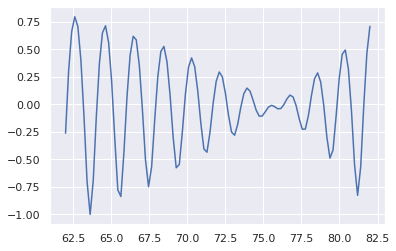

In [111]:
# Trabajo en angulos medidos desde el azimut, los angulos de elevacion (gps) estan medidos desde el suelo. VOY A LLAMAR ELEVACION A LOS MEDIDOS DESDE AZIMUT
# Las cotas que suponemos para nuestro suelo es entre 8º y 28º de elevacion y corresponden a ep entre 4 y 40. 

# inputs
epsilon = 15.5
ssup = 0.015
altura = 3.0

entrada = [epsilon,ssup,altura]

# voy a analizar como varia al meter mas o menos mediciones, es decir, cambiando la discretizacion en los angulos
discretizacion = 100
thi = np.linspace(62*pi/180,82*pi/180, discretizacion)

# s0 = au.generadorS0(elevacion,epsilon1,epsilon2,de,ssup,sinf,altura)
s0 = patron(epsilon,ssup,altura)
plt.plot(thi*180/pi,s0.eval())

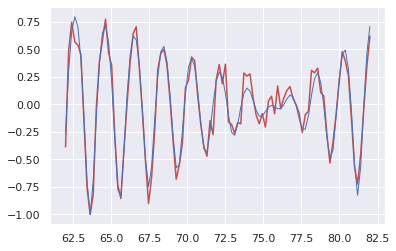

In [127]:
# #agrego ruido
noise = 10 #Valor en porcentaje del ruido que quiero ej: 10 = 10% de ruido en la medicion
# noise = 5 #Valor en porcentaje del ruido que quiero ej: 10 = 10% de ruido en la medicion
# noise = 3 #Valor en porcentaje del ruido que quiero ej: 10 = 10% de ruido en la medicion
# noise = 1 #Valor en porcentaje del ruido que quiero ej: 10 = 10% de ruido en la medicion


pert = patron_ruidoso(epsilon,ssup,altura)
plt.plot(thi*180/pi,pert.eval() ,c='r')
plt.plot(thi*180/pi,s0.eval(),linewidth=1,c='b')

In [128]:
# variance is the average of the squared differences from the mean.
var = np.mean((pert.eval() - s0.eval())**2)
sd = var**0.5
print('sd = ' + str(sd))

sd = 0.09383308443646861


(array([ 2.,  0.,  6., 16., 23., 21., 19.,  7.,  4.,  2.]),
 array([-0.28297454, -0.22812901, -0.17328348, -0.11843795, -0.06359242,
        -0.00874689,  0.04609864,  0.10094417,  0.1557897 ,  0.21063522,
         0.26548075]),
 <BarContainer object of 10 artists>)

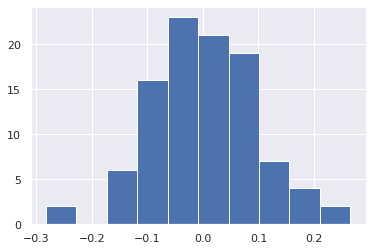

In [129]:
plt.hist(pert.eval() - s0.eval())

In [130]:
type(pert.eval())

numpy.ndarray

In [131]:
t0 = time.time()

# medidos = s0
medidos = pert.eval()


# sig = 0.15 #default

# Parameters

#     mu: float

#         Mean.
#     sigma: float

#         Standard deviation (sigma > 0) (only required if tau is not specified).
#     tau: float

#         Precision (tau > 0) (only required if sigma is not specified).


# sig = 5*sd # ruido que anda
sig = sd



errores = np.asarray(len(s0.eval())*[sig])

muestreo = 3000

# traza = modelo(medidos,errores,muestreo,elevacion)
traza, ppc, model = modelo(medidos,errores,muestreo)

Initializing SMC sampler...
Multiprocess sampling (4 chains in 4 jobs)
INFO (theano.gof.compilelock): Waiting for existing lock by process '34527' (I am process '34530')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/fran/.theano/compiledir_Linux-5.11--generic-x86_64-with-debian-bullseye-sid-x86_64-3.7.11-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '34527' (I am process '34529')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/fran/.theano/compiledir_Linux-5.11--generic-x86_64-with-debian-bullseye-sid-x86_64-3.7.11-64/lock_dir
Stage:   0 Beta: 0.002
Stage:   1 Beta: 0.006
Stage:   2 Beta: 0.017
Stage:   3 Beta: 0.052
Stage:   4 Beta: 0.174
Stage:   5 Beta: 0.576
Stage:   6 Beta: 1.000
/home/fran/miniconda3/envs/bayes/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned 

<Figure size 800x800 with 0 Axes>

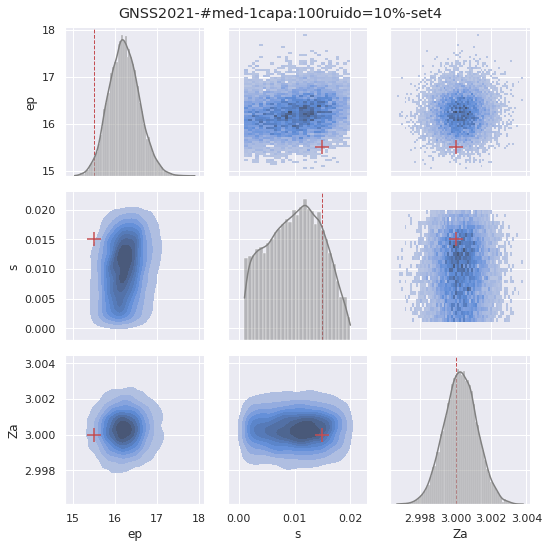

In [132]:
from matplotlib.pyplot import figure

figure(figsize=(10, 10), dpi=80)

plotear = np.stack((traza['ep'],traza['s'],traza['Za'])).T
dfplotear = pd.DataFrame(plotear, columns = ['ep','s','Za'])

g = sns.PairGrid(dfplotear)
g.fig.suptitle('GNSS2021-#med-1capa:'+str(discretizacion)+'ruido='+str(noise)+'%-set4', y=1.01, fontsize = 'large')
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')


for i in range(len(entrada)):
    for j in range(len(entrada)):
        if i == j:
            #ploteo el valor verdadero en las marginales
            g.axes[j,i].axvline(entrada[i], color='r', linestyle='dashed', linewidth=1) #Este me descuajeringa todo, despues veo como arreglarlo
            pass
        else:
            g.axes[j,i].scatter(entrada[i], entrada[j], marker="+", c='r', s=200) #color='k', linestyle='dashed', linewidth=1)
            


In [133]:
Nombre = 'Analisis_de_error/#d='+'F-1capa'+'m='+str(muestreo)+'sigma='+'{:.2f}'.format(sd)+'-Ns='+str(noise)+'%-set4'


In [134]:
Nombre

'Analisis_de_error/#d=F-1capam=3000sigma=0.09-Ns=10%-set4'

In [135]:
g.savefig(Nombre+'.png', dpi=300)

t1 = time.time()
print("Tiempo de ejecución:", t1-t0, 'seg','(', (t1-t0)/3600,  'hs )')

Tiempo de ejecución: 221.96264243125916 seg ( 0.06165628956423865 hs )


In [136]:
e1 = traza['ep']
# e2 = traza['ep2']
# d = traza['d']
s1 = traza['s']
# s2 = traza['s2']
Za = traza['Za']

guardar = [e1,s1,Za]

f2 = np.savetxt(Nombre+'.txt',guardar, fmt='%s', delimiter=';')

In [137]:
# ep1 = 25
# ep2 = 33
# d = 0.1
# s1 = 0.01
# s2 = 0.015
# z = 3.15

/home/fran/miniconda3/envs/bayes/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


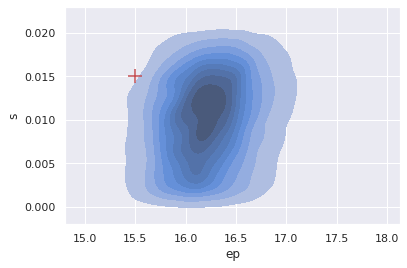

In [138]:
a = sns.kdeplot(traza['ep'],traza['s'], fill=True)#, cmap='cubehelix',thresh = 0,levels=100)
a.set(xlabel='ep', ylabel='s')
a.scatter(epsilon, ssup, marker="+", c='r', s=200)
fig = a.get_figure() 
# fig.savefig('Analisis_de_error/ep1ep2.png',dpi = 300)

In [139]:
#PPC
import arviz as az

<AxesSubplot:xlabel='obs'>

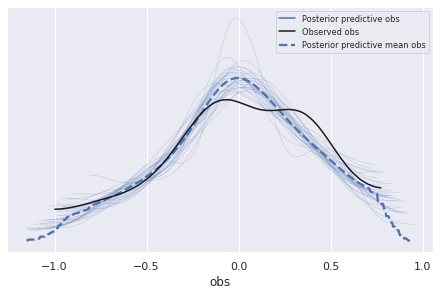

In [140]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model))

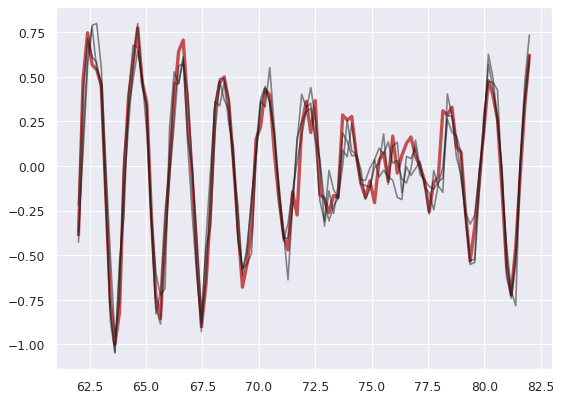

In [141]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

plt.plot(thi*180/pi,pert.eval(),linewidth=3,c='r')

alphaPPC = 0.5

plt.plot(thi*180/pi, ppc['obs'][0,:], alpha = alphaPPC, c='k')
plt.plot(thi*180/pi, ppc['obs'][4,:], alpha = alphaPPC, c='k')
plt.plot(thi*180/pi, ppc['obs'][8,:], alpha = alphaPPC, c='k')


In [63]:
pm.Normal()

TypeError: __new__() missing 1 required positional argument: 'name'